In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [2]:
def true_1D_1(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1;
    y = np.exp(-3.0*x) + np.exp(2.0*x)
    return y
    

In [3]:
level = "medium"
label = "1D_SODE_tanh" + level

u_coeff = 6.0
fo_val = -1.0

loss_thresh = 0.005

x = np.linspace(0,2,100).reshape(-1,1)

bc1_x = x[0].reshape(-1,1)
bc1_y = true_1D_1(x[0]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y_bc1_train = torch.from_numpy(bc1_y).float().to(device)
    

bc2_x = x[0].reshape(-1,1)
x_bc2_train = torch.from_numpy(bc2_x).float().to(device)
bc2_val = torch.tensor(fo_val,device=device)
bc2_val = bc2_val.view(1,1)

x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
y_true = true_1D_1(x_test)
y_true_tensor = torch.from_numpy(y_true).float().to(device)
y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

In [4]:
def colloc_pts(N_f,seed):
    #Collocation Points
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y)
    x01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    
    x_coll_train = lb + (ub-lb)*sampling(N_f)
    x_coll_train = np.vstack((x_coll_train, bc1_x.reshape(-1,1))) # append training points to collocation points 

    return x_coll_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
            
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(2.0)
        

    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
            
        a = self.linears[-1](a) 
         
        return a
    

    def forward_derivs(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2.0*(x - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = x.float()
        
        k_mean = np.zeros((2,3))
        k_std = np.zeros((2,3))
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            n = self.n.cpu().detach().numpy()
            alpha = self.alpha.cpu().detach().numpy()
            a_np = a.cpu().detach().numpy()
            a1_np = n*alpha[:,i]*(1-np.square(a_np))
            a2_np = np.square(n*alpha[:,i])*-2*a_np*(a1_np)
            
            k_mean[i,0] = np.mean(a_np)
            k_std[i,0] = np.std(a_np)
            k_mean[i,1] = np.mean(a1_np)
            k_std[i,1] = np.std(a1_np)
            k_mean[i,2] = np.mean(a2_np)
            k_std[i,2] = np.std(a2_np)
            
            
        a = self.linears[-1](a) 
        
        return k_mean,k_std
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - u_coeff*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

In [6]:
def train_step(x_coll,f_hat):
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat)
        loss.backward()
        
        return loss

    k_mean,k_std = PINN.forward_derivs(x_coll)
    optimizer.step(closure)
   
    
    return k_mean,k_std

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    # beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    k_mean = np.zeros((max_iter,2,3))
    k_std = np.zeros((max_iter,2,3))
    
    x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
    f_hat = torch.zeros(x_coll.shape[0],1).to(device)
    
    loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat).cpu().detach().numpy()
    data_update(loss_np)
    for i in range(max_iter):
        x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        a,b = train_step(x_coll,f_hat)
        k_mean[i,:,:] = a
        k_std[i,:,:] = b
        
        
        # print("k =", k[i])
        loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat).cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return k_mean,k_std

In [9]:
N_f = 1000
x_coll = torch.from_numpy(colloc_pts(N_f,0)).float().to(device)
f_hat = torch.zeros(x_coll.shape[0],1).to(device)

max_reps = 1
max_iter = 75



train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    beta_val = []
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    layers = np.array([1,50,50,1]) #9 hidden layers
    PINN = Sequentialmodel(layers)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

    k_mean,k_std = train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)    
    
    print('Training time: %.2f' % (elapsed_time[reps]))

# mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "beta": beta_full, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold,"k":k}
# savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3.4172454 Test MSE 388.9390518225752 Test RE 1.0053177673954743
1 Train Loss 2.8054311 Test MSE 389.55042416734995 Test RE 1.006107585409602
2 Train Loss 2.5694673 Test MSE 390.2158693971243 Test RE 1.006966554846194
3 Train Loss 2.4921665 Test MSE 390.0449159618838 Test RE 1.0067459548354618
4 Train Loss 2.41709 Test MSE 386.6925620198917 Test RE 1.0024102338061707
5 Train Loss 2.4018888 Test MSE 385.4424666415047 Test RE 1.0007886318893833
6 Train Loss 2.3875132 Test MSE 384.62599226642067 Test RE 0.9997280955922122
7 Train Loss 2.3835597 Test MSE 383.8424266448871 Test RE 0.9987092461728541
8 Train Loss 2.37865 Test MSE 383.0078207756223 Test RE 0.9976228860826125
9 Train Loss 2.3763514 Test MSE

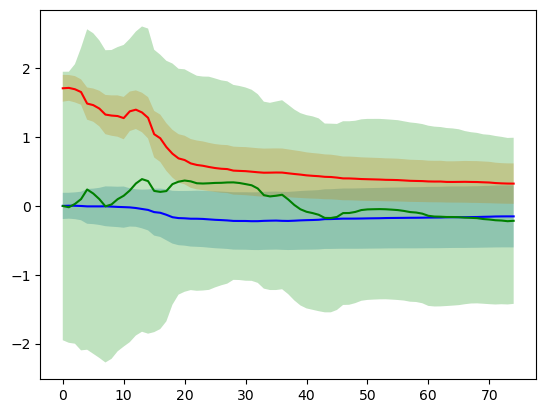

In [10]:
#Epochs, Layers, derivs
layer_num = 1
plt.plot(k_mean[:,layer_num,0],'b')
plt.fill_between(range(0,75),k_mean[:,layer_num,0] - 0.5*k_std[:,layer_num,0],k_mean[:,layer_num,0] + 0.5*k_std[:,layer_num,0],alpha=0.3)
plt.plot(k_mean[:,layer_num,1],'r')
plt.fill_between(range(0,75),k_mean[:,layer_num,1] - 0.5*k_std[:,layer_num,1],k_mean[:,layer_num,1] + 0.5*k_std[:,layer_num,1],alpha=0.3)
plt.plot(k_mean[:,layer_num,2],'g')
plt.fill_between(range(0,75),k_mean[:,layer_num,2] - 0.5*k_std[:,layer_num,2],k_mean[:,layer_num,2] + 0.5*k_std[:,layer_num,2],alpha=0.3)

In [11]:
mdic = {"k_mean":k_mean,"k_std":k_std}
savemat('k_atanh.mat', mdic)